# Autoencoder

In [1]:
import tensorflow as tf
import numpy as np
import sklearn.preprocessing as prep
import matplotlib.pyplot as plt
%matplotlib inline

## Setting

In [2]:
# Parameters
transfer_function = tf.nn.sigmoid # tf.nn.relu, tf.nn.softplus, tf.nn.sigmoid, tf.nn.tanh
dropout_probability = 0.9
training_epochs = 10
batch_size = 128
display_step = 1

## data set

In [3]:
# Check out https://www.tensorflow.org/get_started/mnist/beginners for
# more information about the mnist dataset

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
X_train, X_test = mnist.train.images, mnist.test.images
n_samples = int(mnist.train.num_examples)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Help functions

In [4]:
def standard_scale(X_train, X_test):
    preprocessor = prep.StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    return X_train, X_test

In [5]:
def inverse_transform(X_train_original, X_processed):
    preprocessor = prep.StandardScaler().fit(X_train_original)
    X = preprocessor.inverse_transform(X_processed)
    
    return X

In [6]:
def get_random_block_from_data(data, batch_size):
    start_index = np.random.randint(0, len(data) - batch_size)
    
    return data[start_index:(start_index + batch_size)]

## autoencoder model

In [7]:
class Autoencoder(object):

    def __init__(self, n_input, n_hidden, transfer_function=tf.nn.softplus, optimizer = tf.train.AdamOptimizer()):
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.transfer = transfer_function

        network_weights = self._initialize_weights()
        self.weights = network_weights

        # model
        self.x = tf.placeholder(tf.float32, [None, self.n_input])
        self.hidden = self.transfer(tf.add(tf.matmul(self.x, self.weights['w1']), self.weights['b1']))
        self.reconstruction = tf.add(tf.matmul(self.hidden, self.weights['w2']), self.weights['b2'])

        # cost
        self.cost = 0.5 * tf.reduce_sum(tf.pow(tf.subtract(self.reconstruction, self.x), 2.0))
        self.optimizer = optimizer.minimize(self.cost)

        init = tf.global_variables_initializer()
        self.sess = tf.Session()
        self.sess.run(init)


    def _initialize_weights(self):
        all_weights = dict()
        all_weights['w1'] = tf.get_variable("w1", shape=[self.n_input, self.n_hidden],
            initializer=tf.contrib.layers.xavier_initializer())
        all_weights['b1'] = tf.Variable(tf.zeros([self.n_hidden], dtype=tf.float32))
        all_weights['w2'] = tf.Variable(tf.zeros([self.n_hidden, self.n_input], dtype=tf.float32))
        all_weights['b2'] = tf.Variable(tf.zeros([self.n_input], dtype=tf.float32))
        return all_weights

    def partial_fit(self, X):
        cost, opt = self.sess.run((self.cost, self.optimizer), feed_dict={self.x: X})
        return cost

    def calc_total_cost(self, X):
        return self.sess.run(self.cost, feed_dict = {self.x: X})

    def transform(self, X):
        return self.sess.run(self.hidden, feed_dict={self.x: X})

    def generate(self, hidden = None):
        if hidden is None:
            hidden = self.sess.run(tf.random_normal([1, self.n_hidden]))
        return self.sess.run(self.reconstruction, feed_dict={self.hidden: hidden})

    def reconstruct(self, X):
        return self.sess.run(self.reconstruction, feed_dict={self.x: X})

    def getWeights(self):
        return self.sess.run(self.weights['w1'])

    def getBiases(self):
        return self.sess.run(self.weights['b1'])

In [8]:
autoencoder = Autoencoder(n_input=784,
                          n_hidden=200,
                          transfer_function=transfer_function,
                          optimizer=tf.train.AdamOptimizer(learning_rate = 0.001)
                         )

In [9]:
for epoch in range(training_epochs):
    avg_cost = 0.
    total_batch = int(n_samples / batch_size)
    # Loop over all batches
    for i in range(total_batch):
        batch_xs = get_random_block_from_data(X_train, batch_size)

        # Fit training using batch data
        cost = autoencoder.partial_fit(batch_xs)
        # Compute average loss
        avg_cost += cost / n_samples * batch_size

    # Display logs per epoch step
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch + 1), "cost=", "{:.9f}".format(avg_cost))

print("Total cost: " + str(autoencoder.calc_total_cost(X_test)))

Epoch: 0001 cost= 1771.175496875
Epoch: 0002 cost= 687.547584091
Epoch: 0003 cost= 456.295976776
Epoch: 0004 cost= 350.171713494
Epoch: 0005 cost= 287.485226172
Epoch: 0006 cost= 248.472731357
Epoch: 0007 cost= 221.128024361
Epoch: 0008 cost= 199.544238281
Epoch: 0009 cost= 184.276023793
Epoch: 0010 cost= 171.983789950
Total cost: 12961.6


/home/ubuntu/tf_py3.6/lib/python3.6/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


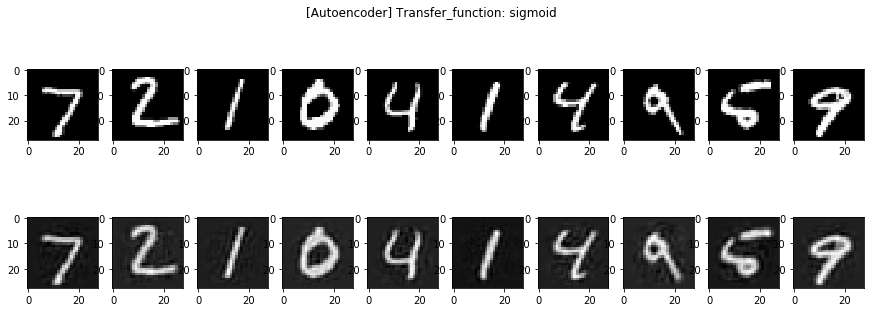

In [11]:
examples_to_show = 10
start_img = 0
idx = range(start_img, start_img + examples_to_show)
X_test_original = mnist.test.images
func_name = str(autoencoder.transfer).split(' ')[1]
suptitle_name = '[Autoencoder] Transfer_function: %s' % (func_name)

reconstructed_images = autoencoder.reconstruct(X_test[idx, :])
f, a = plt.subplots(2, examples_to_show, figsize=(15, 5))
for i in range(start_img, examples_to_show):
    a[0][i].imshow(np.reshape(X_test_original[i, :], (28, 28)), cmap=plt.get_cmap('gray'))
    a[1][i].imshow(np.reshape(reconstructed_images[i, :], (28, 28)), cmap=plt.get_cmap('gray'))
plt.suptitle(suptitle_name)
f.show()
# f.savefig('figures/testImage_%s_dropout_%.3f.png' % (func_name, autoencoder.dropout_probability))

In [12]:
autoencoder.weights

{'b1': <tensorflow.python.ops.variables.Variable at 0x7ff54e5c03c8>,
 'b2': <tensorflow.python.ops.variables.Variable at 0x7ff59c7831d0>,
 'w1': <tensorflow.python.ops.variables.Variable at 0x7ff54e5c05f8>,
 'w2': <tensorflow.python.ops.variables.Variable at 0x7ff549f0a160>}

In [13]:
encoder_weight = autoencoder.sess.run(autoencoder.weights['w1'])
decoder_weight = autoencoder.sess.run(autoencoder.weights['w2'])

In [14]:
encoder_weight[0, :]

array([ 0.00038962,  0.00833354,  0.07803845,  0.02058135, -0.06274301,
       -0.02263983, -0.04038927,  0.05396989, -0.0325094 , -0.05604301,
       -0.05389865,  0.04821528, -0.02736764,  0.00769231, -0.0625421 ,
       -0.01746404,  0.06032549,  0.02362495,  0.03446253,  0.01339041,
       -0.02663083, -0.05635141, -0.02583317, -0.05959602,  0.00900278,
       -0.04437819,  0.03537195, -0.04944295,  0.06170714, -0.0779857 ,
        0.06221895,  0.01582841, -0.05705753,  0.05109403,  0.06891301,
        0.02633356,  0.01664858,  0.04724811,  0.06946763,  0.05181126,
       -0.00617614, -0.01922395,  0.02095261, -0.05835959, -0.04138216,
        0.01493468,  0.01198877,  0.0394756 , -0.07004599,  0.02432837,
       -0.0322751 ,  0.00714447, -0.0200746 , -0.0015616 ,  0.0243509 ,
        0.06269006,  0.01531474,  0.0772572 , -0.04108711, -0.03081313,
        0.04448771, -0.04189953, -0.04077968,  0.03849711,  0.05611247,
       -0.00464466,  0.02552292, -0.02803842,  0.03864868,  0.02

In [15]:
decoder_weight[:, 0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

In [16]:
encoder_bias = autoencoder.sess.run(autoencoder.weights['b1'])
decoder_bias = autoencoder.sess.run(autoencoder.weights['b2'])

In [17]:
encoder_bias

array([-0.13357101, -0.23961769, -0.48234138, -0.43509299, -0.51697659,
       -0.05140929, -0.11568417, -0.06295555, -0.16384991, -0.39208955,
        0.06382751,  0.06141694,  0.46796462,  0.15397143,  0.06387828,
        0.51919895, -0.27493358, -0.46910146, -0.23290406,  0.08477611,
        0.14788984,  0.40778804, -0.2673122 ,  0.25719944,  0.14117359,
       -0.08750495, -0.4039501 , -0.39751765, -0.30855101,  0.52552629,
        0.25393236, -0.23058972, -0.47911578, -0.05143639, -0.04918427,
       -0.16456769, -0.49790424, -0.06158284,  0.27264601, -0.46693125,
       -0.28908753, -0.35240915, -0.42391667, -0.47561705, -0.31088313,
       -0.20509624, -0.48057541,  0.06755415, -0.34364864, -0.22037566,
       -0.05472723, -0.4755809 ,  0.13372387,  0.39601818,  0.28661475,
        0.16053206,  0.11242924, -0.25161603,  0.37863401, -0.468337  ,
       -0.29796827,  0.41309938, -0.4514066 ,  0.17449252, -0.35115242,
       -0.08947695, -0.48337504,  0.44911063,  0.13543986, -0.08

In [18]:
decoder_bias

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         2.24680116e-04,   1.74658257e-04,   5.03993360e-05,
         1.37445473e-04,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,  -4.10735047e-05,
         2.29524358e-05,   5.90822056e-05,  -8.81056694e-05,
         3.64584645e-04,   1.00788916e-03,   1.22744311e-03,
         1.03216956e-03,   1.58606342e-03,   2.46795779e-03,
         2.81456369e-03,   2.83816340e-03,   3.15401354e-03,
         2.15525273e-03,   1.62029557e-03,   2.01765657e-03,
         1.81225617e-03,

In [19]:
encoder_bias.shape

(200,)

In [20]:
decoder_bias.shape

(784,)